# Explainability Approaches with RandomForest on the Pima Indians Diabetes dataset

##  Libraries

In [1]:
# Data preprocessing
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from lime.lime_tabular import LimeTabularExplainer
import shap
# ML algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Dataset 

To show different explaination techniques we fitted a Random Forest on the Pima Indians Diabetes dataset from Kaggle.

[Dataset on Kaggle](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database/data)

The dataset comprises 768 samples with 8 features and a binary class label.
The columns in the Pima Indians Diabetes dataset represent the following:
-  Pregnancies: Number of times pregnant
-  Glucose: Plasma glucose concentration from a 2 hours oral glucose tolerance test
-  BloodPressure: Diastolic blood pressure (mm Hg)
-  SkinThickness: Triceps skinfold thickness (mm)
-  Insulin: 2-Hour serum insulin (mu U/ml)
-  BMI: Body mass index (weight in kg/(height in m)^2)
-  DiabetesPedigreeFunction: Diabetes pedigree function (a function which scores likelihood of diabetes based on family history)
- Age: Age in years
- Outcome: Outcome variable (0 or 1), where 1 indicates the presence of diabetes and 0 indicates the absence.

In [2]:
data = pd.read_csv("data/diabetes.csv")
print('dimension: ', data.shape)
print('features: ', data.columns)
data.head()

dimension:  (768, 9)
features:  Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Descriptive Statistics

In [3]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


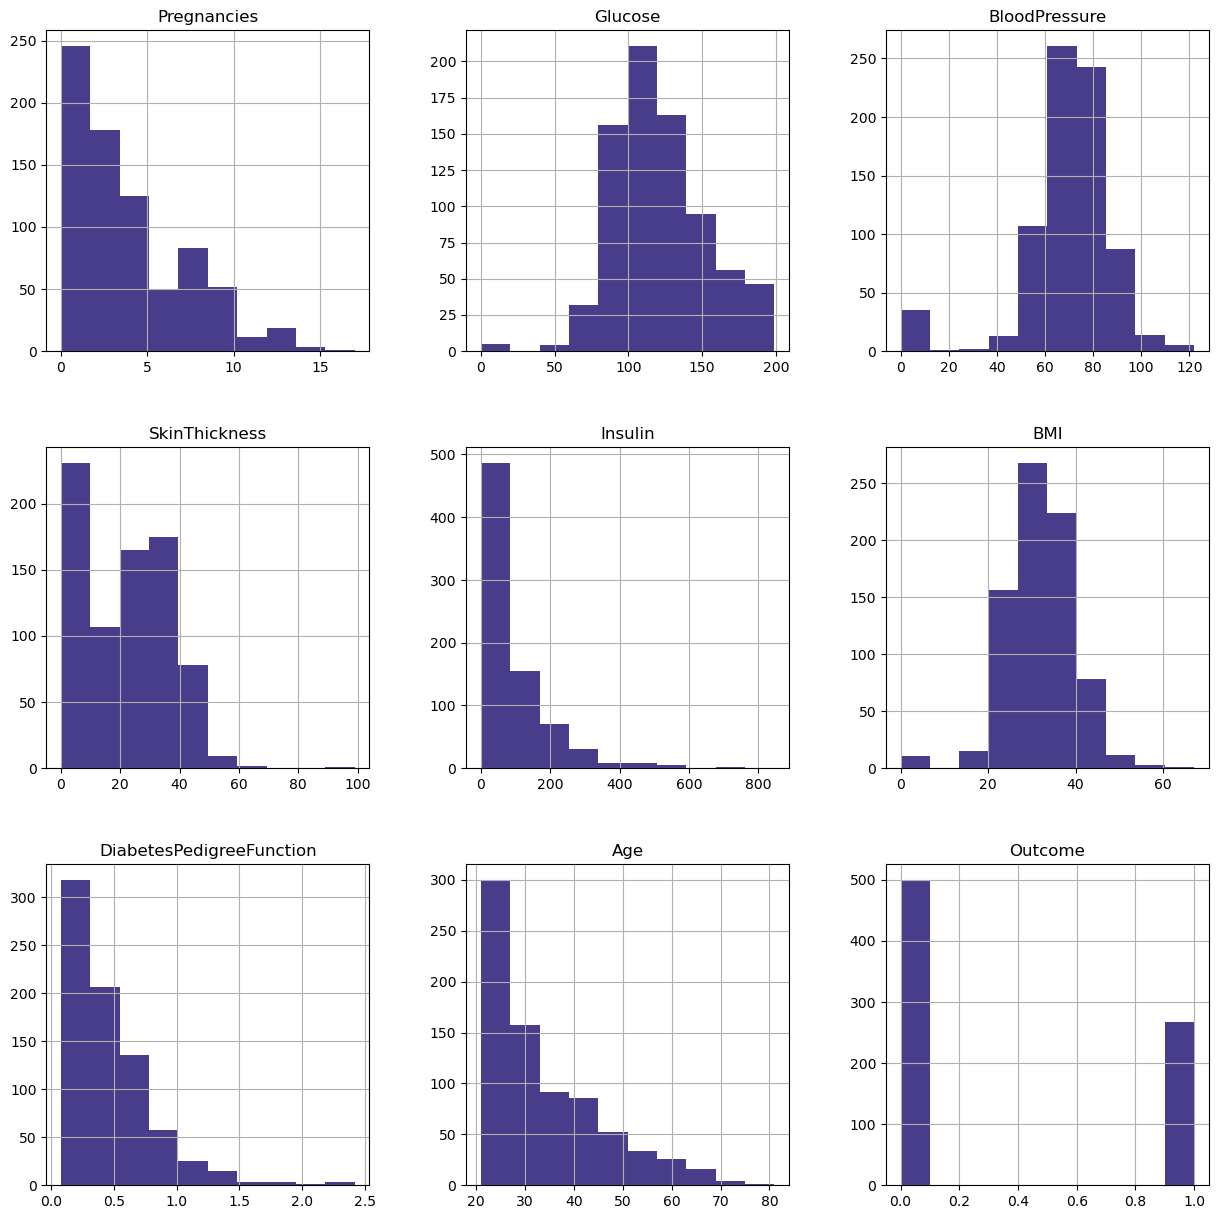

In [4]:
hist_plot = data.hist(figsize = (15,15), color = "#483D8B")

### Check class balance:

This is also visible in the histogram above.

In [5]:
count_class = data.groupby("Outcome").size()
count_class

Outcome
0    500
1    268
dtype: int64

### Divide the dataset on train/test:

In [6]:
X = data.drop('Outcome', axis=1)
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=0,
                                                    stratify=y)

## Random Forest

Random Forest is an ensemble learning algorithm used for both classification and regression tasks. It constructs a multitude of decision trees during training and outputs the mode (classification) or average prediction (regression) of the individual trees. Each tree is built on a random subset of the training data, and a random subset of features is considered at each split, introducing diversity and reducing overfitting. Random Forest is known for its high accuracy, robustness to noisy data, and ability to capture complex relationships in the data. It is a versatile and widely used machine learning algorithm in various domains.

### Fit a RandomForest model:

In [7]:
rf_model = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

### Check model accuracy:

In [8]:
y_predicted = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_predicted)
print("Accuracy: ",  accuracy*100, "%")

Accuracy:  80.51948051948052 %


# Partial dependence plot (PDP)

## Partial dependence plot (PDP) - questions according to Hohman et al.

WHY:
* Model Interpretability & Feature Impact : PDP is employed to enhance the interpretability of machine learning models by illustrating the relationship between the target response and specific input features. It helps in understanding the impact of selected features on the model's predictions.
* Explainability . PDP aids in explaining model predictions to model users, making it easier for non-experts to comprehend the model's behaviour and decision-making process.

WHO:
* Data scientists and model developers use PDP to analyse and interpret the behaviour of their models, gaining insights into the relationship between input features and the target response.
* Non-experts : benefit from PDP as it provides a clear visual representation, making it accessible for individuals who may not have a technical background.

WHAT:
* PDP visualizes the relationship between the target response and selected input features while marginalizing over the values of other features , it shows how the target response changes with variations in the chosen features 

HOW:
* Aggregated Response Across Feature Values PDP calculates the aggregated response of the model across different values of the selected input features while keeping other features fixed. This is achieved by generating predictions for various combinations of feature values and then averaging the model's response.
* Visualization through Line Plots :  PDP is often visualized through line plots, showing the trend of the target response as the values of the input features change..

WHEN:
* Model Analysis and Interpretation : PDP is commonly used during the model analysis phase, especially after the model is trained, to gain insights into the behavior of the model and understand the impact of specific features.

WHERE:
* Model Development and Validation PDP is applied in the context of model development and validation, where it helps in fine-tuning models and ensuring they align with the expected behaviour.


Partial dependence plots (PDP) show the dependence between the target response and a set of input features of interest, marginalizing over the values of all other input features (the 'complement' features). Intuitively, we can interpret the partial dependence as the expected target response as a function of the input features of interest.

Due to the limits of human perception, the size of the set of input features of interest must be small (usually, one or two) thus the input features of interest are usually chosen among the most important features.


## First create a PDP for all features seperately:

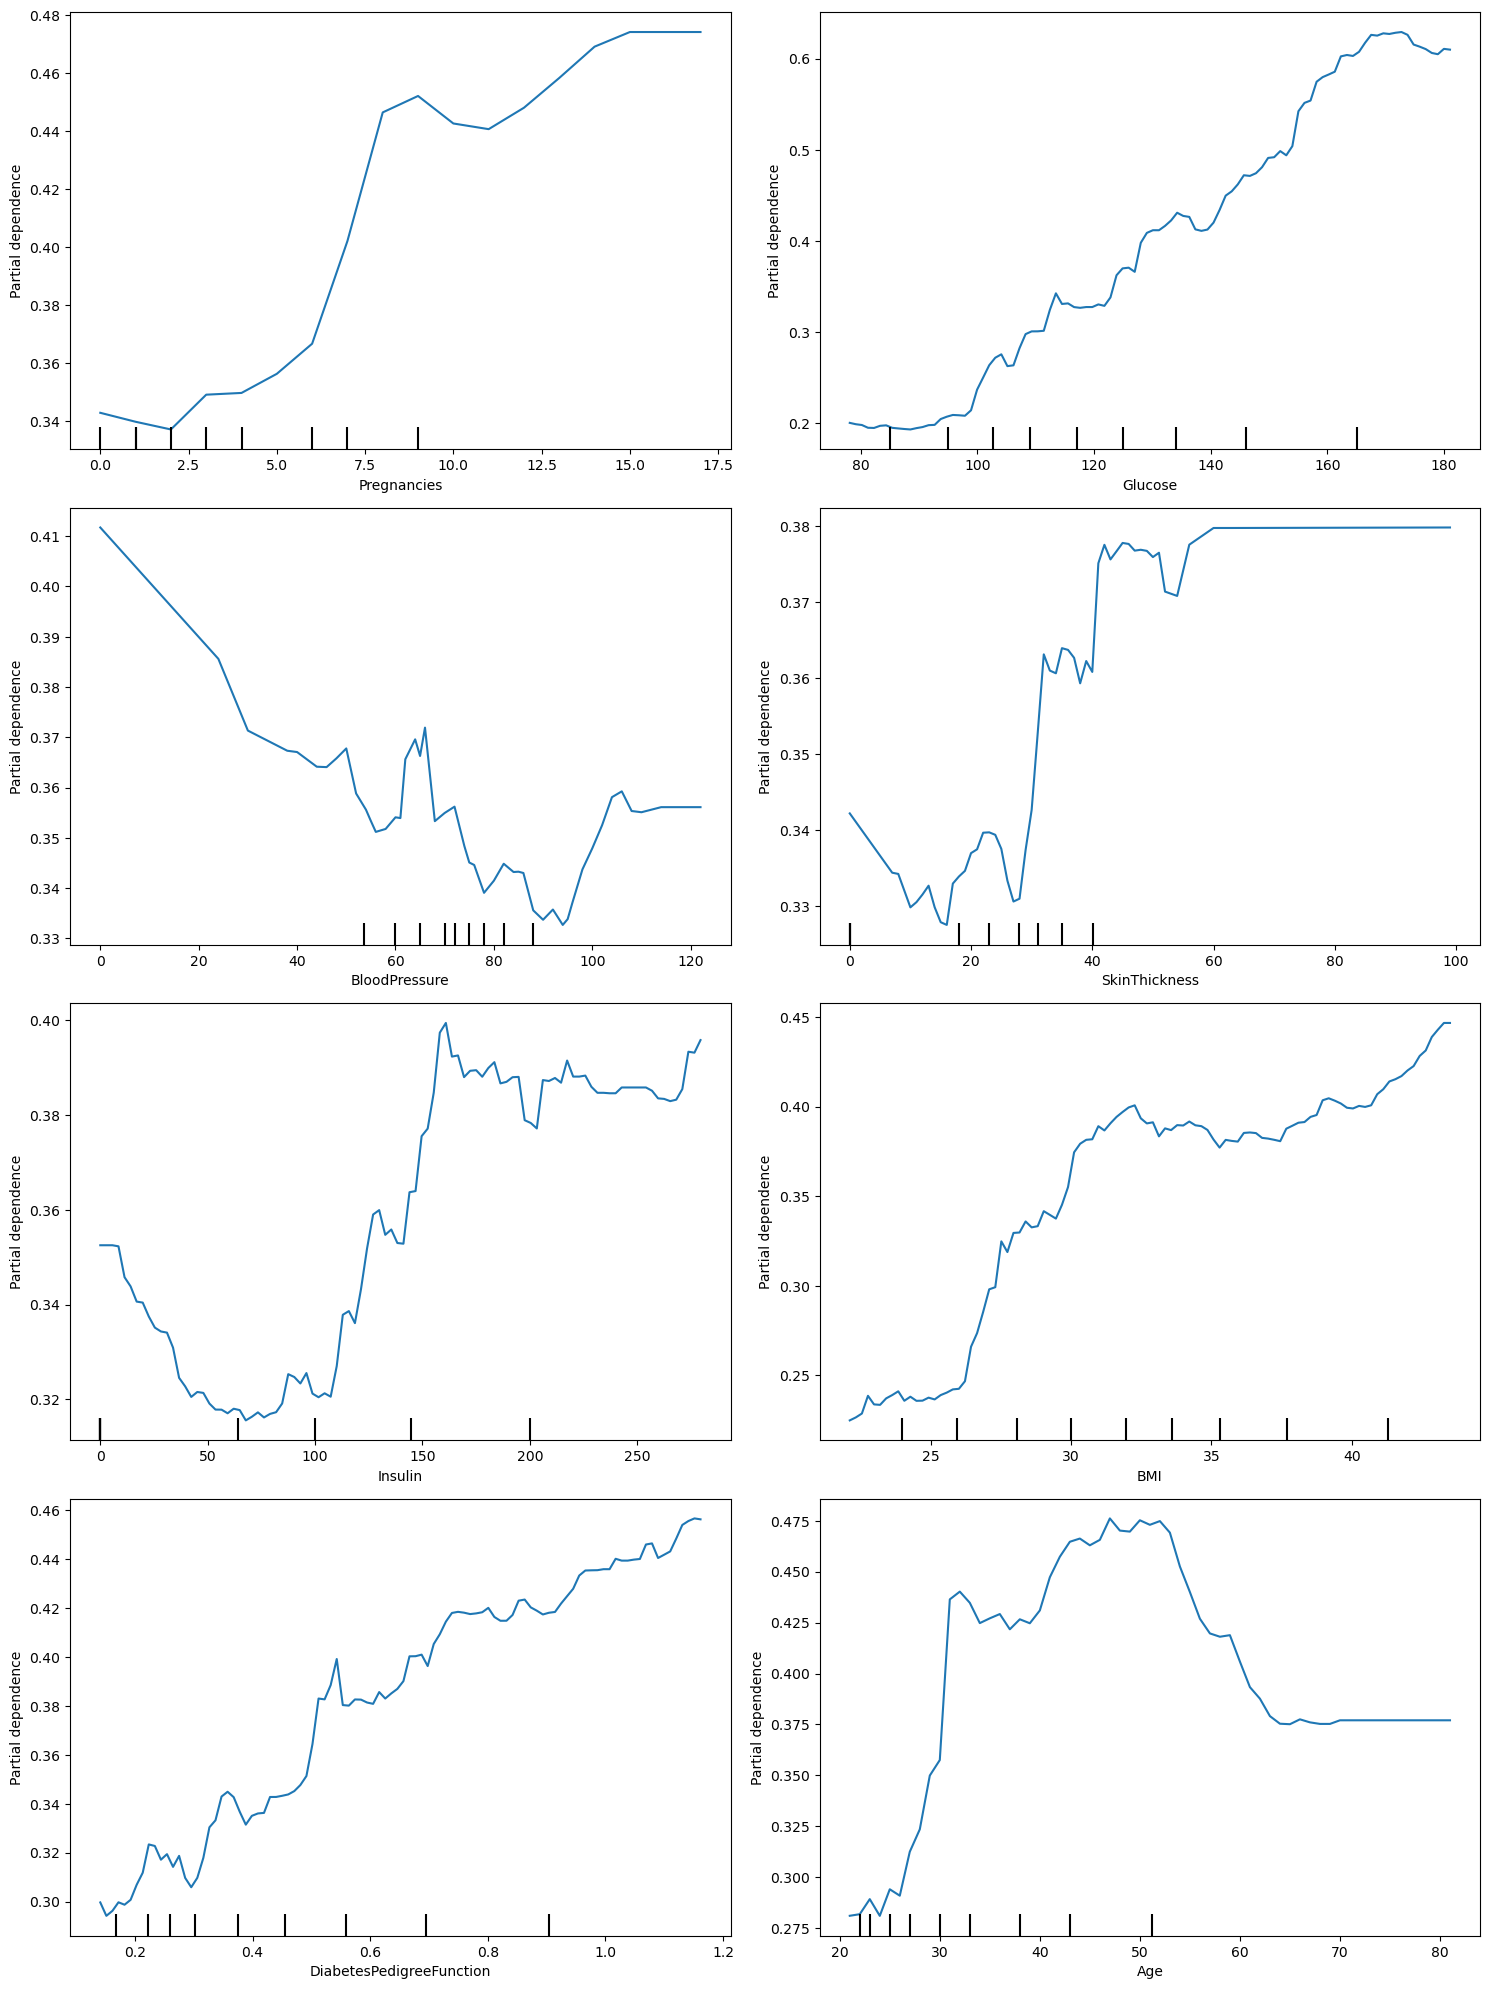

In [9]:
# Create a subplot with 2 columns and 4 rows for the 8 features
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 20))

# List of all feature names from the dataset
feature_names = X_train.columns

# Iterate over features and create partial dependence plots
for i, feature in enumerate(feature_names):
    ax = axs[i // 2, i % 2]  # Determine the position of the subplot
    PartialDependenceDisplay.from_estimator(rf_model, X_train, features=[feature], ax=ax, feature_names=feature_names)

plt.tight_layout()
plt.show()

# ICE & PDP


## Individual conditional expectation (ICE)- questions according to Hohman et al.

WHY:
* Capturing Heterogeneous Relationships :  ICE plots are employed to capture and visualize heterogeneous relationships between the target function and an input feature. Unlike PDPs, ICE plots provide insights into individual sample variations, revealing nuances that might be obscured by averaging in PDPs.
* Unveiling Interaction Effects : ICE plots are crucial when interactions between features and the target response exist. They uncover how each sample responds uniquely to changes in the chosen input feature, providing a more detailed understanding of complex relationships.

WHO:
* Non-experts. Researchers studying interaction effects within models benefit from ICE plots as they provide a granular view of how individual samples contribute to the overall model behaviour. 

WHAT:
* Individual Conditional Expectations :  ICE plots visualize the conditional expectations of the target response for each sample individually, illustrating how predictions change for a specific input feature.

HOW:
* Plotting Individual Sample Lines  plots represent the dependence between the target function and an input feature by plotting individual lines for each sample. Each line on the plot shows the predictions for a single sample as the input feature varies.
* Addressing Interactions through individual lines : plots explicitly address interactions by providing a detailed view of how each sample responds to variations in the input feature, revealing patterns that might be overlooked in aggregate analyses. 

WHEN:
* Exploring Interactions in Model Output :  particularly useful when exploring models with intricate interactions, offering insights during the analysis phase after model training.

WHERE:
* In XAI class. This method (as well as the others described in these slides) were applied in the course of the Lab for XAI class.


Similar to a PDP, an individual conditional expectation (ICE) plot shows the dependence between the target function and an input feature of interest. However, unlike a PDP, which shows the average effect of the input feature, an ICE plot visualizes the dependence of the prediction on a feature for each sample separately with one line per sample. Due to the limits of human perception, only one input feature of interest is supported for ICE plots.

While the PDPs are good at showing the average effect of the target features, they can obscure a heterogeneous relationship created by interactions. When interactions are present the ICE plot will provide many more insights.

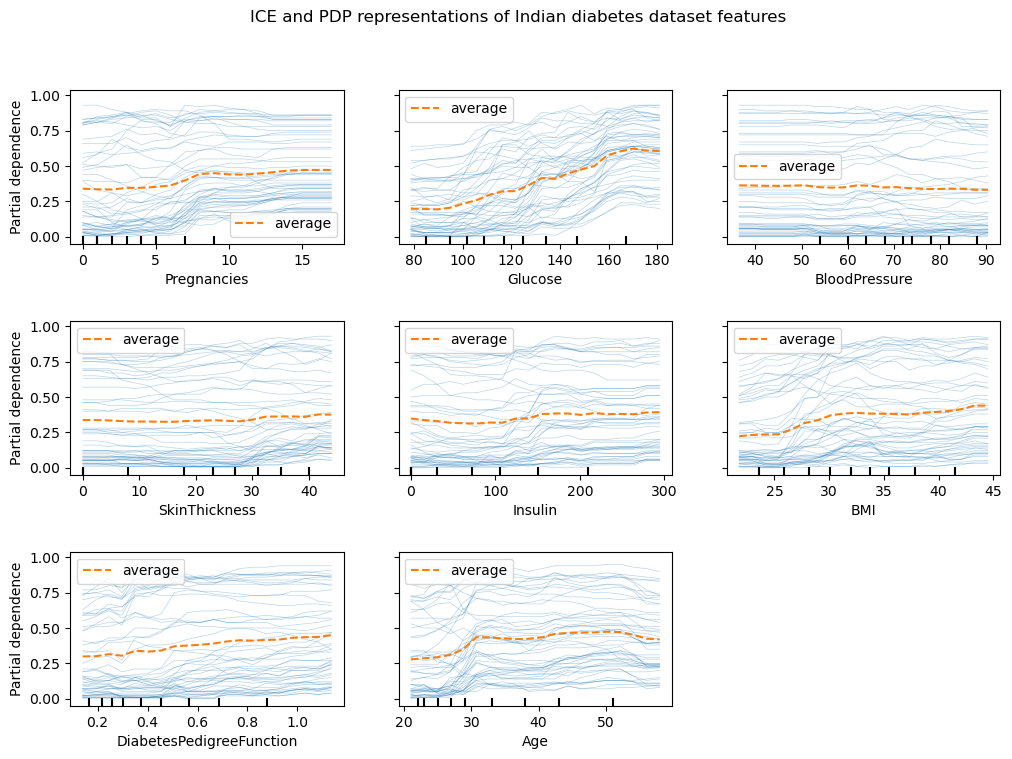

In [10]:
feature_names = X_train.columns


display = PartialDependenceDisplay.from_estimator(
    rf_model,
    X,
    feature_names,
    kind="both",
    subsample=50,
    n_jobs=3,
    grid_resolution=20,
    random_state=0,
)

display.figure_.suptitle("ICE and PDP representations of Indian diabetes dataset features "  )
display.figure_.subplots_adjust(hspace=0.5)
#make the display bigger
display.figure_.set_size_inches(12, 8)
plt.show()

Some ICE lines being flat or showing a decrease at certain levels may indicate that the relationship between the target variable and the feature of interest is not consistent across all observations. When interactions are present, the effect of a single feature on the target variable may vary depending on the values of other features. Interactions refer to the dependencies or relationships between two or more features that affect the target variable.

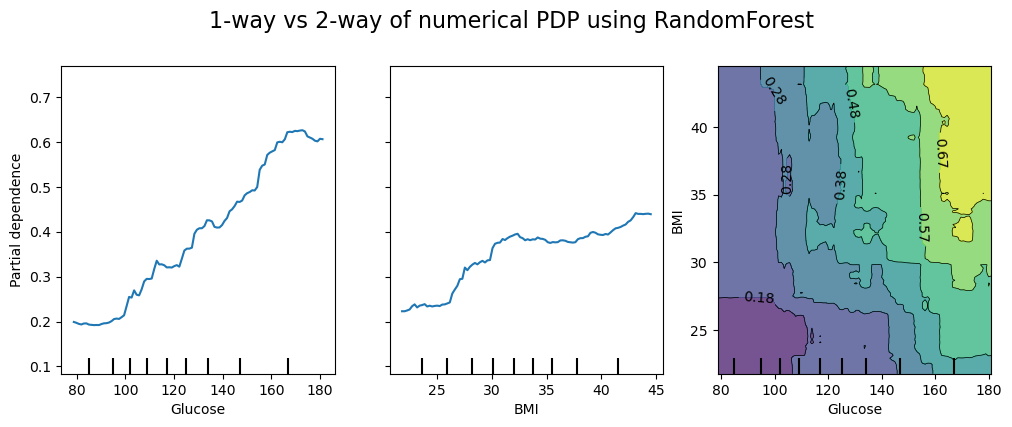

In [11]:
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(rf_model, X, [1, 5,(1, 5)], ax=ax)
plt.suptitle("1-way vs 2-way of numerical PDP using RandomForest", x=0.5, y=1.02, ha='center', fontsize=16)
plt.show()

**Interpretation**

* **One-way PDPs tell us about the interaction between the target class (-ve or +ve ) and an input feature . The left plot in the above figure shows the effect of the Glucose on whether the person's probability  is a diabetic patient or not. we can clearly see that a higher Glucose is related with a higher dependency to determine the probability of the class. Similarly, we could analyze the effect of the BMI on whether the person's probability  is a diabetic patient or not.(middle plot).**

* **PDPs with two input features of interest show the interactions among the two features. For example, the two-variable PDP in the above figure shows the dependence of "the person's probability  is a diabetic patient or not" on joint values of Glucose and BMI. We can clearly see an interaction between the two features: with a Glucose lower than 120 , mainly the mass has a strong impact on determining the person's class. For higer Glucose values , both the Glucose and the BMI have an impact on determine whether the person's probability is a diabetic patient or not.**



# LIME

## Local interpretable model-agnostic explanations (LIME)- questions according to Hohman et al.

WHY:
* Interpretability of Black Box Models : LIME is employed to enhance the interpretability of black box machine learning models by providing local, interpretable explanations for individual predictions. Understanding why a model made a specific prediction is crucial for building trust and making informed decisions. 
* Local Surrogate Models for Transparency : LIME focuses on training local surrogate models, providing transparency at the individual prediction level. This approach enables users to grasp the decision-making process for a specific instance, offering insights that may not be apparent at a global level.

WHO:
* Data Scientist & Model Developers : Data scientists and model developers use LIME to interpret and explain individual predictions of black box models, facilitating model debugging and refinement.

WHAT:
* Local Surrogate Models  :  LIME implements local surrogate models that approximate the predictions of the black box model for individual instances. These models provide interpretable insights into why a specific prediction was made.

HOW:
* Probing Black Box Model Predictions: LIME simulates probing the black box model by generating a new dataset with perturbed samples and corresponding black box model predictions. This dataset is used to train local interpretable models, such as Lasso or decision trees, weighted by the proximity of the samples to the instance of interest.
* Training Interpretable Models Locally  : LIME trains interpretable models locally, focusing on the neighborhood of the instance of interest. The interpretability is achieved by capturing the relationship between the perturbed samples and the corresponding black box model predictions in this local region..

WHEN:
* Individual Prediction Explanation  :  LIME is used when there is a need to explain individual predictions of a black box model, providing insights into the decision-making process for specific instances..

WHERE:
* In XAI class. This method (as well as the others described in these slides) were applied in the course of the Lab for XAI class.



Local surrogate models are interpretable models that are used to explain individual predictions of black box machine learning models. Local interpretable model-agnostic explanations (LIME) is a paper in which the authors propose a concrete implementation of local surrogate models. Surrogate models are trained to approximate the predictions of the underlying black box model. Instead of training a global surrogate model, LIME focuses on training local surrogate models to explain individual predictions.

The idea is quite intuitive. First, forget about the training data and imagine you only have the black box model where you can input data points and get the predictions of the model. You can probe the box as often as you want. Your goal is to understand why the machine learning model made a certain prediction. LIME tests what happens to the predictions when you give variations of your data into the machine learning model. LIME generates a new dataset consisting of perturbed samples and the corresponding predictions of the black box model. On this new dataset LIME then trains an interpretable model, which is weighted by the proximity of the sampled instances to the instance of interest. The interpretable model can be anything from the interpretable models, for example Lasso or a decision tree. The learned model should be a good approximation of the machine learning model predictions locally, but it does not have to be a good global approximation. 

Create a new explainer using the LimeTabularExplainer. You need to pass:
- Training data with categorical values converted to LIME format. It also needs to be a numpy array.
- Specify a mode.
- feature_names: a list of names for your columns.
- random_state: pick one!

In [12]:
explainer = LimeTabularExplainer(X_train.values, mode="classification", feature_names=feature_names, random_state=42)

Select one observation:

In [13]:
i = 0
observation = X_test.iloc[i]
print(observation)
print("class: ", y_test.iloc[i])
print("prediction: ", rf_model.predict_proba([observation]).argmax())

Pregnancies                  2.000
Glucose                     56.000
BloodPressure               56.000
SkinThickness               28.000
Insulin                     45.000
BMI                         24.200
DiabetesPedigreeFunction     0.332
Age                         22.000
Name: 680, dtype: float64
class:  0
prediction:  0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In order to explain a prediction, we use the explain_instance method on our explainer. This will generate new data with perturbated features around the observation and learn a local linear model. It needs to take:

- our observation as a numpy array
- a function that uses our model to predict probabilities given the data (in same format we've passed in our explainer).
- (optional) num_features: number of features to consider in explanation

In [14]:
explanation = explainer.explain_instance(observation, rf_model.predict_proba)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Visualize the explanation with lime visualization functions.

In [15]:
explanation.show_in_notebook()

- **LIME Explanation:**
  - LIME provides local, interpretable rules to explain predictions for a specific instance.
  - The rules indicate conditions influencing the local model's prediction, with each condition contributing to the final prediction.

- **Instance-Specific Rules:**
  - Low values of `Glucose` (<= 100) and `BMI` (<= 27.3) contribute positively to predicting class 0.
  - Low values of `Age` (<= 24.00) and `DiabetesPedigreeFunction` (<= 0.37) also contribute positively to the prediction.
  - The values of `Pregnancies`, `BloodPressure`, `SkinThickness`, and `Insulin` do not contribute much to the prediction for this instance. 
  - One could mention that `BloodPressure` is the only feature that has a negative contribution to the prediction.


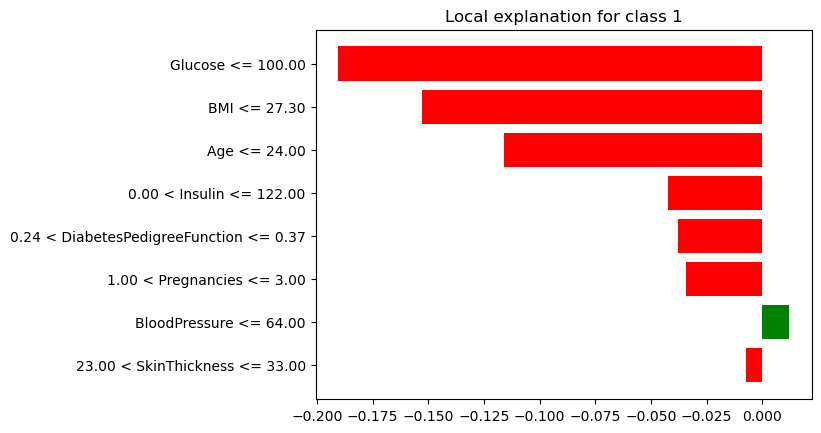

In [16]:
explanation.as_pyplot_figure()
plt.show()

In [17]:
i = 99
observation = X_test.iloc[i]
print(observation)
print("class: ", y_test.iloc[i])
print("prediction: ", rf_model.predict_proba([observation]).argmax())

Pregnancies                   3.000
Glucose                     121.000
BloodPressure                52.000
SkinThickness                 0.000
Insulin                       0.000
BMI                          36.000
DiabetesPedigreeFunction      0.127
Age                          25.000
Name: 678, dtype: float64
class:  1
prediction:  0


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


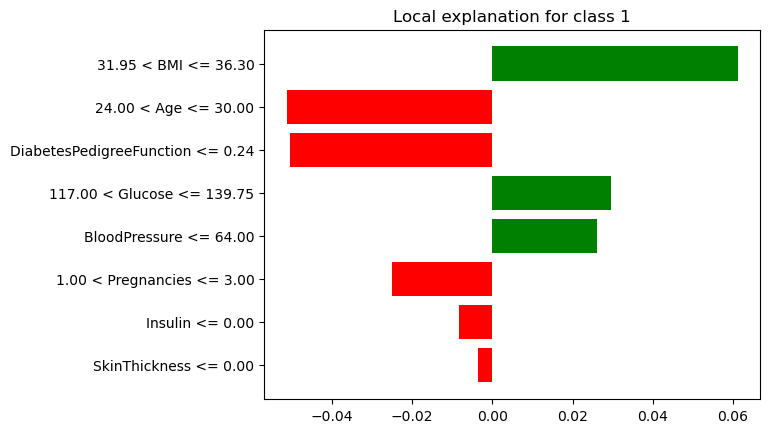

In [18]:
explanation = explainer.explain_instance(observation, rf_model.predict_proba)
explanation.as_pyplot_figure()
plt.show()

# Shapely


## Shapley values - questions according to Hohman et al.

WHY:
* Interpretability & Explainability. Shapley values help users to see which features, i.e. pixels or parts of an image, helped the model to choose a label.
* Teaching Deep Learning Concepts. This technique can also help non-experts to understand how deep learning works for image classification in general - models “scan” images to identify patterns that later will be used in classification.

WHO:
* Non-experts. This technique seems more suitable for non-experts by helping them understand what is happening inside “the black box”.

WHAT:
* Aggregated information. This technique shows the relationship between the input image and the learned features that the model considers most important.

HOW:
* Instance-based Analysis & Exploration. In our example, we calculate Shapley values for each individual instance in order to see which image regions are important for this specific image.
* Analyzing Groups of Instances. Although we didn’t do it in this case, it is possible to apply this method to, for example, several images with the same label to see if similarities in how the model recognizes them.
* Algorithms for Attribution & Feature Visualization. We applied an algorithm to see which parts of an image were more influential in categorizing the image.

WHEN:
* After training. The algorithm was applied on already trained model, images from the test set were used in the calculation.

WHERE:
* In XAI class. This method (as well as the others described in these slides) were applied in the course of the Lab for XAI class.


Shapley values are used to fairly allocate the contribution of each feature to the prediction of a specific instance.

The key idea behind Shapley values is to address the question: "How should the contribution or 'credit' for a specific prediction be distributed among the features?" Shapley values provide a way to fairly distribute the value of a coalition (a subset of features) among its members (individual features) based on their marginal contributions.

In [19]:
# Initialize JS visualization code for Shapley
shap.initjs()

In [20]:
explainer = shap.TreeExplainer(rf_model)

In [21]:
all_shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value[0], all_shap_values[0], features=X_train)

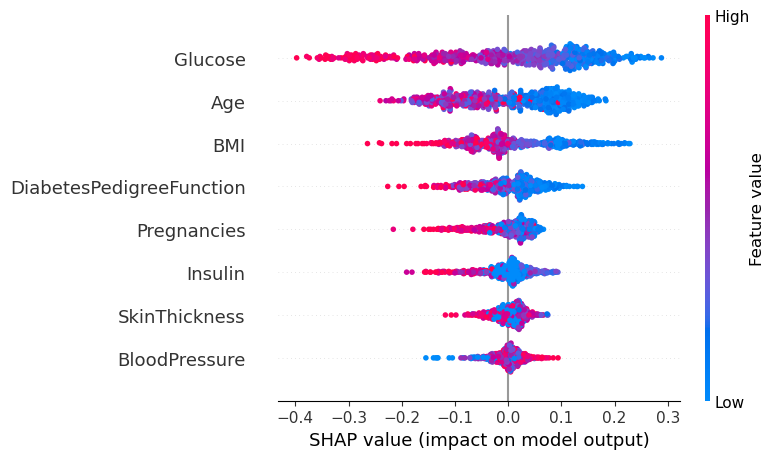

In [22]:
shap.summary_plot(all_shap_values[0], features=X_train, feature_names=feature_names)

- **Feature Importance:**
  - Features at the top of the plot (with higher feature values) have a more significant positive impact on the model's output.
  - Features at the bottom of the plot (with lower feature values) have a more significant negative impact on the model's output.


- **Shapley Values:**
  - Positive Shapley values indicate a positive contribution to the model's prediction, pushing the output higher.
  - Negative Shapley values indicate a negative contribution to the model's prediction, pushing the output lower.


- **Horizontal Position:**
  - The horizontal position of each bar represents the magnitude of the Shapley value.
  - Bars on the right with longer lengths indicate features that positively contribute more to the prediction.
  - Bars on the left with longer lengths indicate features that negatively contribute more to the prediction.


# Diverse Counterfactual Explanations (DiCE)

## DiCE  - questions according to Hohman et al.

Why:
* Interpretability and Explainability of based on an instance of the data to gain local understanding of
the model

Who:
* Model Developer & Builders or potential model users

What:
* Explaining how the change of some feature values of an instance has an influence in outcome class

How:
* This is achieved by generating diverse counterfactual explanations. Counterfactuals represent
instances where certain feature values are altered to produce a different predicted class, typically the
opposite of the original class. Analyzing these counterfactuals reveals the impact of individual
features on the predicted outcome.

When:
* The interpretability and explanation process takes place after the model has been trained. Once the
RandomForest model is trained, the prediction function is employed to generate counterfactuals.

Where:
* This information and methodology are documented and discussed in publications such as ArXiv and
the Proceedings of the 2020 Conference on Fairness, Accountability, and Transparency. Visit the
link for more detail https://github.com/interpretml/DiCE


Diverse Counterfactual Explanations (DICE) is a counterfactual explanation technique designed to explain predictions for individual instances. It is a local and model-agnostic method, making it compatible with any machine learning model. DICE provides a clear interpretation by answering the question: "What needs to be changed to produce the desired outcome?"

## Counterfactual Generation Process

The process of generating counterfactual explanations in DICE involves asking which specific features of an instance need to be modified to produce a different class membership compared to the original, unmodified features of the instance. Two main approaches are employed for counterfactual generation:

1. **Trial and Error:**
   - Counterfactuals are generated through trial and error, iteratively modifying feature values to observe changes in class membership.

2. **Minimize a Loss Function:**
   - A loss function is defined to guide the modification of features. The goal is to minimize this loss function to achieve the desired outcome while altering as few features as possible.

## Key Characteristics of DICE

- **Local and Model-Agnostic:**
  - DICE is a local explanation method, providing insights into individual instances. It is also model-agnostic, making it applicable to a wide range of machine learning models.

- **Interpretability:**
  - DICE has a clear interpretation, showing how changes in one or more feature values impact the class membership.

- **Ease of Human Interpretation:**
  - Counterfactual explanations generated by DICE are easily interpretable by humans, facilitating a better understanding of model predictions.

- **Minimal Requirements:**
  - DICE only requires the prediction function to observe the generation of counterfactual examples, making it relatively simple to implement.

## Disadvantages

One notable disadvantage of DICE is that it produces multiple counterfactuals per instance. This can result in a diverse set of explanations, potentially making it challenging for users to interpret or choose among them. 

See the different dataframes of counterfactuals for a detailed view of the multiple explanations provided by DICE.



## More details on Diverse Counterfactual Explanations (DiCE)

In the following we include a part of the explanation of DiCE from the orginal github repository in [Link to Github Repo](https://github.com/interpretml/DiCE). For further details please visit the given Link.

Exploring "what-if" scenarios is an important way to inspect a machine learning (ML) model. The DiCE library helps you to understand an ML model by generating "what-if" data points that lead to the desired model output. Formally, such "what-if" data points are known as *counterfactuals*, described by the following question:
> Given that the model's output for input $x$ is $y$, what would be the output if input $x$ is changed to $x'$?

The answer to the above question can be obtained by simply inputting $x'$ to the ML model. However, in many cases, we are interested in the reverse question: what changes to $x$ would lead to a desired change in model's output? When inspecting a classifier, for instance, we are often interested in knowing the changes to $x$ that will lead to a desired predicted class. For a regressor, we may be interested in the changes to $x$ that lead to a desired output range. Ideally, these changes should be *proximal* to bring out the local decision logic of the classifier, *sparse* to highlight a limited set of features, and *diverse* to show the different ways in which the same outcome can be achieved. The DiCE library provides an easy interface to generate such counterfactual examples for any ML model.


Finally, the counterfactuals for an input data point can be used to derive a **local importance score** for each feature. The local feature importance score ranks features by their frequency of being changed in the generated counterfactuals. Among all the features, necessary features are likely to be changed more often to generate proximal counterfactuals and therefore will receive a higher score. You can use `features_to_vary` and `permitted_range` parameteres to refine the search space for the counterfactuals and consequently, the local importance score. Given a set of input points, the local importance score can be aggregated to provide a global importance score. Compared to explanation methods like LIME or SHAP, feature importance scores generated by DiCE tend to give importance to a larger number of features; more details are in this [paper](https://arxiv.org/abs/2011.04917).

**`In the following only a limited number of counterfactuals were plotted because of the large amount of counterfactuals.`** 

In [23]:
# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions
d = dice_ml.Data(dataframe=data, continuous_features=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age'], outcome_name='Outcome')

# Using sklearn backend
m = dice_ml.Model(model=rf_model, backend="sklearn")

# Using method="random" for generating CFs
exp = dice_ml.Dice(d, m, method="random")

The `total_CFs` parameter denotes the number of counterfactuals that are used to create the local importance. More the better.

In [24]:
## We can start producing counterfactual for the first instance of the test set

e1 = exp.generate_counterfactuals(X_test[0:1], total_CFs=2, desired_class="opposite")
e1.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00, 14.48it/s]

Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,56,56,28,45,24.200001,0.332,22,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,186.0,-,-,-,45.7,-,-,-
1,-,191.0,-,-,-,-,-,33.0,1.0


In [25]:
e2 = exp.generate_counterfactuals(X_test[:10],
                                  total_CFs=2,
                                  desired_class="opposite",
                                  features_to_vary=['Glucose']
                                  )
e2.visualize_as_dataframe(show_only_changes=True)

 40%|████      | 4/10 [00:00<00:00, 31.12it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


 80%|████████  | 8/10 [00:00<00:00, 33.03it/s]

No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec
No Counterfactuals found for the given configuration, perhaps try with different parameters... ; total time taken: 00 min 00 sec


100%|██████████| 10/10 [00:00<00:00, 29.28it/s]

Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,56,56,28,45,24.200001,0.332,22,0



No counterfactuals found!
Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,92,62,25,41,19.5,0.482,25,0



No counterfactuals found!
Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,100,74,12,46,19.5,0.149,28,0



No counterfactuals found!
Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,7,97,76,32,91,40.900002,0.871,32,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,193.0,-,-,-,-,-,-,1.0
1,-,126.0,-,-,-,-,-,-,1.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,151,62,31,120,35.5,0.692,28,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,88.0,-,-,-,-,-,-,0.0
1,-,29.0,-,-,-,-,-,-,0.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3,87,60,18,0,21.799999,0.444,21,0



No counterfactuals found!
Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,11,111,84,40,0,46.799999,0.925,45,1



No counterfactuals found!
Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,83,68,0,0,18.200001,0.624,27,0



No counterfactuals found!
Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,100,70,26,50,30.799999,0.597,21,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,190.0,-,-,-,-,-,-,1.0
1,-,179.0,-,-,-,-,-,-,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3,115,66,39,140,38.099998,0.15,28,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,174.0,-,-,-,-,-,-,1.0
1,-,165.0,-,-,-,-,-,-,1.0


# Insight

**`The feature "Glucose" susceptible to changes in the class assignment if the feature (value) was slightly changed, although all other features remained the same. This clearly showed the "Glucose" was one of the important features. Overall we could see that changes to "Glucose" resulted more often to class membership changes than any other featues`** 

Counterfactual for the instances 15 till 30 which age restricted from 20 to 70

In [26]:
e3 = exp.generate_counterfactuals(X_test[15:30],
                                  total_CFs=2,
                                  desired_class="opposite",
                                  permitted_range={'Age': [20, 70]})
e3.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 15/15 [00:00<00:00, 15.19it/s]

Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,88,62,24,44,29.9,0.422,23,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,-,-,492.0,-,-,47.0,1.0
1,-,175.0,-,-,-,-,-,44.0,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,88,30,42,99,55.0,0.496,26,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,166.0,13.0,-,-,-,-,-,1.0
1,-,149.0,-,-,-,-,-,-,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,7,81,78,40,48,46.700001,0.261,42,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,191.0,-,-,-,-,-,-,1.0
1,-,148.0,-,-,144.0,-,-,-,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5,108,72,43,75,36.099998,0.263,33,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,-,-,-,-,2.307,28.0,-
1,-,190.0,-,-,-,-,-,37.0,1.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,7,178,84,0,0,39.900002,0.331,41,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,49.0,-,-,-,-,-,67.0,0.0
1,-,109.0,-,99.0,-,-,-,-,0.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,131,64,14,415,23.700001,0.389,21,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,166.0,-,-,-,62.5,-,-,1.0
1,-,181.0,-,-,-,60.9,-,-,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,109,64,44,99,34.799999,0.905,26,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,17.0,-,-,-,-,45.4,-,-,1.0
1,-,-,-,-,291.0,-,-,41.0,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,11,127,106,0,0,39.0,0.19,51,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,-,-,274.0,-,-,-,1.0
1,-,179.0,-,19.0,-,-,-,-,1.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,131,0,0,0,43.200001,0.27,26,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2.0,-,-,-,-,25.0,-,-,0.0
1,-,89.0,-,-,-,-,-,-,0.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3,142,80,15,0,32.400002,0.2,63,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,13.0,-,-,-,-,-,1.0
1,-,-,0.0,-,-,-,-,-,1.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,128,64,42,0,40.0,1.101,24,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,-,29.0,632.0,-,-,-,0.0
1,-,53.0,-,-,-,59.7,-,-,0.0


Query instance (original outcome : 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,4,184,78,39,277,37.0,0.264,31,1



Diverse Counterfactual set (new outcome: 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,32.0,-,-,-,-,-,-,0.0
1,-,70.0,-,-,674.0,-,-,-,0.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,95,85,25,36,37.400002,0.247,24,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,-,-,438.0,-,-,38.0,1.0
1,-,198.0,-,-,-,-,1.167,-,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,111,62,13,182,24.0,0.138,23,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,-,-,-,-,35.3,-,42.0,1.0
1,-,-,-,-,-,55.6,-,42.0,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,84,50,23,76,30.4,0.968,21,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,198.0,-,-,-,-,-,53.0,1.0
1,-,-,-,-,438.0,-,-,54.0,-


## 2. Approach using the method "Genetic Algorithm" 

Here, we show how to use DiCE can be used to generate CFs for any ML model by using the genetic algorithm to find the best counterfactuals close to the query point. The genetic algorithm converges quickly, and promotes diverse counterfactuals.
**Reason for usage is the quick convergence because the 'method' to longer. But they produced the same counterfactuals.** 

### Generate diverse counterfactuals

In [27]:
query_instances = X_train[4:6]

In [28]:
# initiate DiceGenetic
exp_genetic = dice_ml.Dice(d, m, method='genetic')

In [29]:
# generate counterfactuals
dice_exp_genetic = exp_genetic.generate_counterfactuals(query_instances, total_CFs=4, desired_class="opposite", verbose=True)

  0%|          | 0/2 [00:00<?, ?it/s]

Initializing initial parameters to the genetic algorithm...
Initialization complete! Generating counterfactuals...
Diverse Counterfactuals found! total time taken: 00 min 00 sec
Initializing initial parameters to the genetic algorithm...
Initialization complete! Generating counterfactuals...
Diverse Counterfactuals found! total time taken: 00 min 00 sec


100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


In [30]:
dice_exp_genetic.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,193,50,16,375,25.9,0.655,24,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,119.0,86.0,39.0,220.0,45.6,0.808,29.0,1.0
0,-,-,76.0,36.0,249.0,36.5,0.875,29.0,1.0
0,7.0,187.0,-,33.0,392.0,33.9,0.826,34.0,1.0
0,-,-,0.0,36.0,249.0,36.5,0.875,53.0,1.0


Query instance (original outcome : 0)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0,111,65,0,0,24.6,0.66,31,0



Diverse Counterfactual set (new outcome: 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-,131.0,88.0,-,-,31.6,0.743,32.0,1.0
0,-,108.0,80.0,-,-,32.3,0.743,44.0,1.0
0,-,123.0,72.0,-,-,31.6,0.743,52.0,1.0
0,-,108.0,80.0,-,-,31.6,0.743,52.0,1.0


## Generating feature attributions (local and global) using DiCE

DiCE can generate feature importance scores using a summary of the counterfactuals generated. Intuitively, a feature that is changed more often when generating proximal counterfactuals for an input is locally important for causing the model's prediction at the input. Formally, counterfactuals operationalize the __necessity__ criterion for a model explanation: _is the feature value necessary for the given model output?_ 

For more details, refer to the paper, [Towards Unifying Feature Attribution and Counterfactual Explanations: Different Means to the Same End](https://arxiv.org/abs/2011.04917).

### Local feature importance scores

These scores are computed for a given query instance (input point) by summarizing a set of counterfactual examples around the point. 

In [31]:
query_instance = X_test
imp = exp.local_feature_importance(query_instance, total_CFs=10)
print(imp.local_importance[0])

100%|██████████| 154/154 [00:16<00:00,  9.15it/s]

{'Glucose': 1.0, 'BMI': 0.7, 'Age': 0.3, 'Pregnancies': 0.0, 'BloodPressure': 0.0, 'SkinThickness': 0.0, 'Insulin': 0.0, 'DiabetesPedigreeFunction': 0.0}


### Local Feature Importance Analysis

Upon analyzing the local feature importance for the test set, several observations can be made:


- **'Glucose':** For most test samples, the local feature importance of 'Glucose' consistently exhibits higher values compared to other features.

- **'BMI', 'DiabetesPedigreeFunction', 'Age':** These features demonstrate similar values in terms of local feature importance across the test set.

This observation suggests that 'Glucose' plays a prominent role at the local level, significantly influencing the model's predictions for individual instances. On the other hand, 'BMI', 'DiabetesPedigreeFunction', and 'Age' appear to have comparable impacts on the model's decisions at the local level that have a slightly less impact than 'Glucose'.

**I have cleared the cell output for looking at the local important list of dicts, running the notebook will help since as you can imagine the output is very long. But it is similar to this dict structure.**


**{'Glucose': 0.55, 'BMI': 0.2909090909090909, 'Age': 0.2305194805194805, 'DiabetesPedigreeFunction': 0.2064935064935065, 'Pregnancies': 0.16688311688311688, 'Insulin': 0.137012987012987, 'BloodPressure': 0.09480519480519481, 'SkinThickness': 0.09480519480519481} only this time for every instance individually.**

### Global feature importance scores

A global importance score per feature can be estimated by aggregating the scores over individual inputs. The more the inputs, the better the estimate for global importance of a feature.

In [32]:
query_instances = X_test
imp = exp.global_feature_importance(query_instances)
print(imp.summary_importance)

100%|██████████| 154/154 [00:17<00:00,  9.04it/s]


{'Glucose': 0.5207792207792208, 'BMI': 0.2902597402597403, 'Age': 0.24285714285714285, 'Insulin': 0.18441558441558442, 'DiabetesPedigreeFunction': 0.17402597402597403, 'Pregnancies': 0.16753246753246753, 'SkinThickness': 0.11623376623376623, 'BloodPressure': 0.09610389610389611}


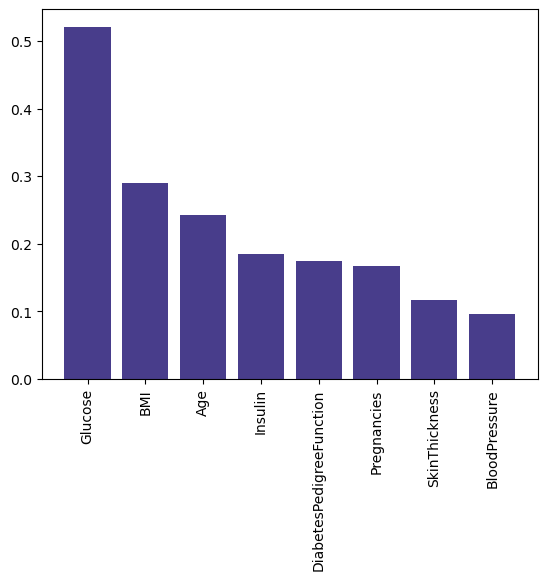

In [33]:
names = list(imp.summary_importance.keys())
values = list(imp.summary_importance.values())

plt.bar(range(len(imp.summary_importance)), values, tick_label=names, color="#483D8B")
plt.xticks(rotation=90)
plt.show()

## Global Feature Importance

The analysis of global feature importance using Dice indicates that the following features are particularly susceptible to changes in input features leading to changes in class membership:

1. **Glucose**
2. **BMI**
3. **Age**
4. **DiabetesPedigreeFunction**

These features exhibit the highest importance levels in influencing the model's predictions. 